In [1]:
from data_loader import LakesDataset
import torch
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
batch_size = 1

train_dataset =LakesDataset(train=True, data_path = '../', patch_size = 1024)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)


examples = iter(train_loader)

samples, labels = next(examples)
print(samples.shape, labels.shape)

torch.Size([1, 30, 3, 1024, 1024]) torch.Size([1, 30, 1, 1024, 1024])


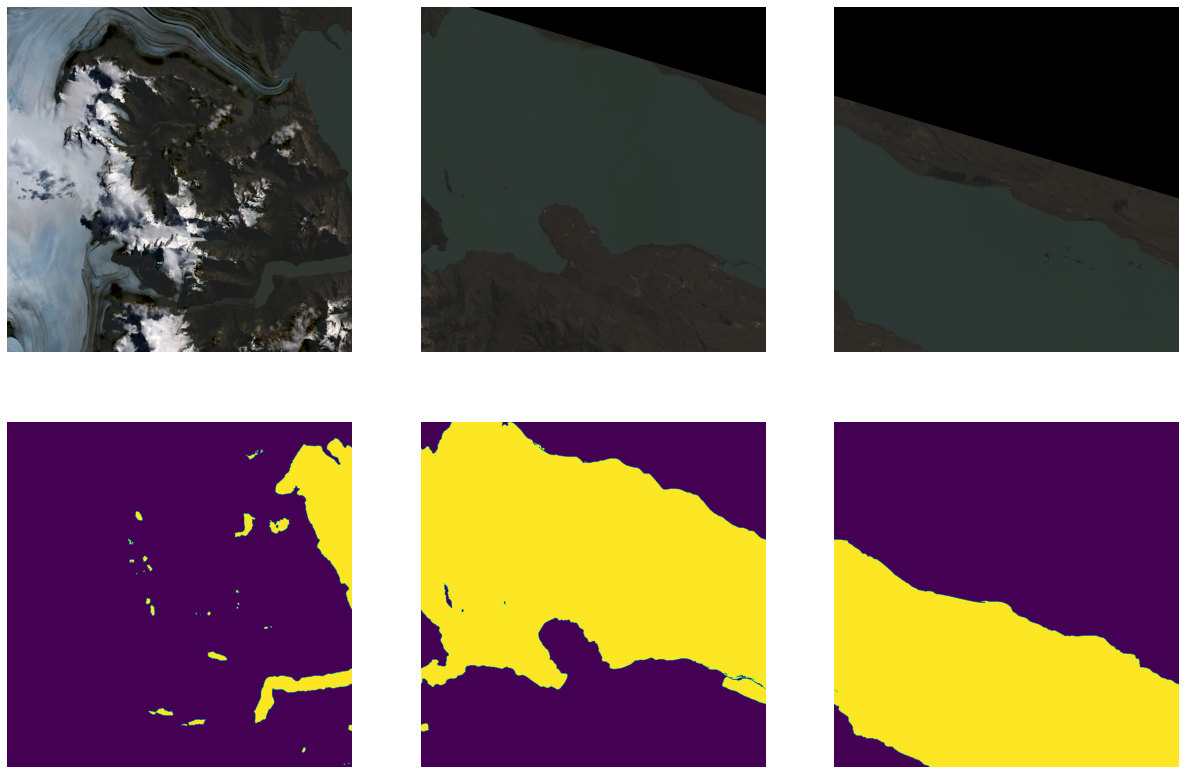

In [12]:
plt.figure(figsize=(21, 14))
for i in range(3):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(samples[0][i+6].permute(1,2,0))
    plt.axis("off")
    ax = plt.subplot(2, 3, i + 4)
    plt.imshow(labels[0][i+6].permute(1,2,0))
    plt.axis("off")